In [1]:
# Install dependencies

import mne, mne_nirs, scipy
import matplotlib.pyplot as plt
from glob import glob
from itertools import compress
from scipy.stats import skew, kurtosis

In [2]:
# - GRAB SUBJECT DATA - #
#
# WARNING: Only run this once, rerunning this will reset the QC order. If accidentally clicked
# you can adjust the next block with last subject QCed and reset order.

subject_folders = glob("/storage1/fs1/perlmansusan/Active/moochie/study_data/P-CAT/R56/restructured_data/PSU_data/fnirs_data/flanker/*/")
checked_folders = []

print(f"Subject length - {len(subject_folders)}")
print(f"Subject folders:\n -{'\n -'.join(subject_folders)}")


Subject length - 30
Subject folders:
 -/storage1/fs1/perlmansusan/Active/moochie/study_data/P-CAT/R56/restructured_data/PSU_data/fnirs_data/flanker/1220/
 -/storage1/fs1/perlmansusan/Active/moochie/study_data/P-CAT/R56/restructured_data/PSU_data/fnirs_data/flanker/1235/
 -/storage1/fs1/perlmansusan/Active/moochie/study_data/P-CAT/R56/restructured_data/PSU_data/fnirs_data/flanker/1236/
 -/storage1/fs1/perlmansusan/Active/moochie/study_data/P-CAT/R56/restructured_data/PSU_data/fnirs_data/flanker/1244/
 -/storage1/fs1/perlmansusan/Active/moochie/study_data/P-CAT/R56/restructured_data/PSU_data/fnirs_data/flanker/1246/
 -/storage1/fs1/perlmansusan/Active/moochie/study_data/P-CAT/R56/restructured_data/PSU_data/fnirs_data/flanker/1232/
 -/storage1/fs1/perlmansusan/Active/moochie/study_data/P-CAT/R56/restructured_data/PSU_data/fnirs_data/flanker/1247/
 -/storage1/fs1/perlmansusan/Active/moochie/study_data/P-CAT/R56/restructured_data/PSU_data/fnirs_data/flanker/1207/
 -/storage1/fs1/perlmansusa

In [3]:
# Update subject pool to last subject
update_subject = '1251'

subject_found = subject_folders[0].split('/')[-2]
while subject_found != update_subject and len(subject_folders) > 0:
    subject_folders.pop(0)
    subject_found = subject_folders[0].split('/')[-2]
    checked_folders.append(subject_found)
    
if subject_found == update_subject:
    print(f"Subject order updated!")
else:
    print(f"Failed to find subject...")


Subject order updated!


In [387]:
# List of Current Checked Subjects
print(f"Previously checked subjects:\n -{'\n -'.join(checked_folders)}")

Previously checked subjects:
 -1114
 -1129
 -1176
 -1115
 -1162
 -1116
 -1178
 -1124
 -1139
 -1125
 -1172
 -1187
 -1126
 -1173
 -1188
 -1112


In [813]:
#  - ITERATE SUBJECT QC - #

# Pop subject off subject pool and QC
subject_folder = subject_folders.pop(0)

snirf_file = glob(f"{subject_folder}/*.snirf")[0]
scan = mne.io.read_raw_snirf(snirf_file, verbose=True)

subject_id = subject_folder.split('/')[-2]
checked_folders.append(subject_id)

print(f"Loaded {subject_id}...")


Loading /storage1/fs1/perlmansusan/Active/moochie/study_data/P-CAT/R56/restructured_data/PSU_data/fnirs_data/flanker/1226/1226.snirf
Loaded 1226...


Reading 0 ... 6147  =      0.000 ...   786.816 secs...


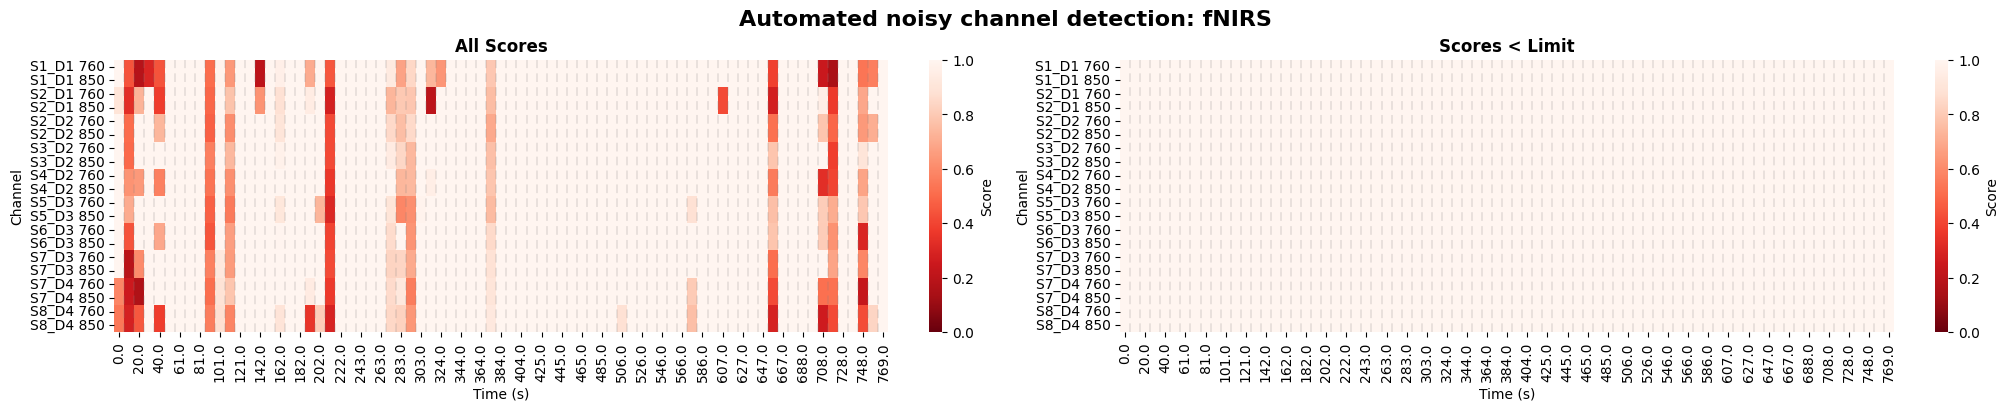

Bad channels in subject 1226 : []


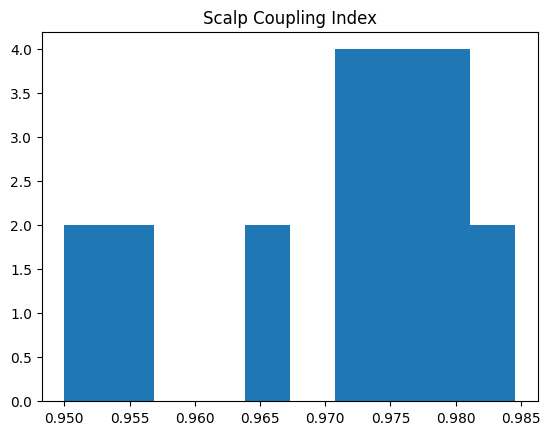

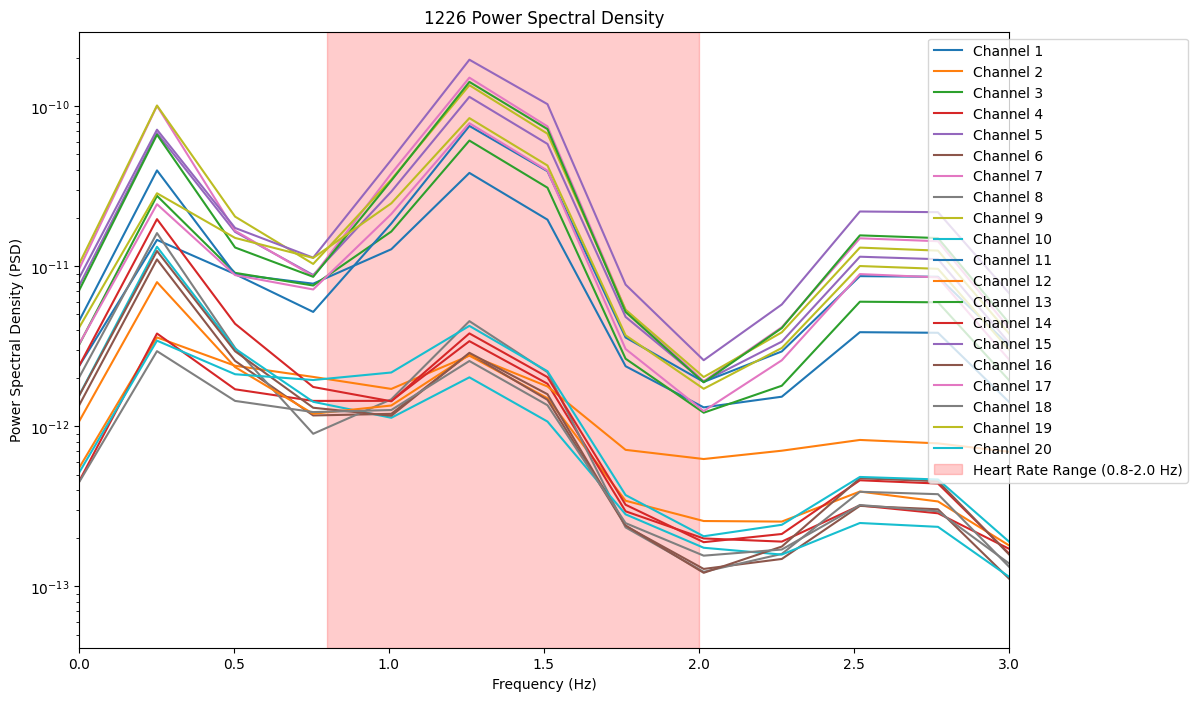

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 2579 samples (330.112 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband ed

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [814]:
# Preprocess data and output peak power and scalp coupling index

# Load raw data
data = scan.load_data()

# Plot peak power
od = mne.preprocessing.nirs.optical_density(data)
od, scores, times = mne_nirs.preprocessing.peak_power(od, time_window=10)

figure = mne_nirs.visualisation.plot_timechannel_quality_metric(od, scores, times, threshold=0.1)
plt.show()

# Plot scalp coupling index
sci = mne.preprocessing.nirs.scalp_coupling_index(od)

od.info['bads'] = list(compress(od.ch_names, sci < 0.8))

if len(od.info['bads']) == len(scan.ch_names):
    print("All channels are bad, skipping subject...")

print("Bad channels in subject", od.info['subject_info']['his_id'], ":", od.info['bads'])

od = mne.preprocessing.nirs.tddr(od)

# If running deconvolution, polynomial detrend to remove pysiological noise without cutting into the frequency spectrum
#if deconvolution:
    #od = polynomial_detrend(od, order=1)

# haemoglobin conversion using Beer Lambert Law 
haemo = mne.preprocessing.nirs.beer_lambert_law(od.copy(), ppf=0.1)

figure, axis = plt.subplots(1, 1)

axis.hist(sci)
axis.set_title(f'Scalp Coupling Index')
plt.show()

# Define heart rate frequency range
heart_rate_low = 0.8  # Lower bound in Hz
heart_rate_high = 2.0  # Upper bound in Hz

# Calculate Power Spectral Density (PSD) for each channel
data = haemo.get_data()

sfreq = 7.81  # Sampling frequency
n_per_seg = int(round(4 * sfreq, 0))  # Length of each segment for Welch's method

psd_list = []
freqs, psd_all_channels = [], []

for i, channel_data in enumerate(data):
    freqs, psd = scipy.signal.welch(channel_data, sfreq, nperseg = n_per_seg)
    psd_all_channels.append(psd)

# Step 3: Plot PSD for each channel with heart rate range highlighted
plt.figure(figsize=(12, 8))

for i, psd in enumerate(psd_all_channels):
    plt.plot(freqs, psd, label=f'Channel {i+1}')

# Highlight the heart rate frequency range
plt.axvspan(heart_rate_low, heart_rate_high, color='red', alpha=0.2, label='Heart Rate Range (0.8-2.0 Hz)')

# Customize plot
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (PSD)')
plt.title(f'{subject_id} Power Spectral Density')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), ncol=1)
plt.xlim(0, 3)  # Limit to frequencies of interest
plt.yscale('log')  # Log scale for better visualization of peaks
plt.show()

# Filter the raw data to obtain the signal and noise components
# Define the signal band (i.e., hemodynamic response function band)
signal_band = (0.01, 0.2)
# Define the noise band (outside of the hemodynamic response)
noise_band = (0.2, 1.0) 

# Extract the signal in the desired band
preproc_signal = haemo.copy().filter(signal_band[0], signal_band[1], fir_design='firwin')

# Extract the noise in the out-of-band frequency range
preproc_noise = haemo.copy().filter(noise_band[0], noise_band[1], fir_design='firwin')

# Calculate the Power Spectral Density (PSD) for signal and noise using compute_psd()
psd_signal = preproc_signal.compute_psd(fmin = signal_band[0], fmax = signal_band[1])
psd_noise = preproc_noise.compute_psd(fmin = noise_band[0], fmax = noise_band[1])

# Extract the power for each component
signal_power = psd_signal.get_data().mean(axis = -1)  # Average power across frequencies for signal
noise_power = psd_noise.get_data().mean(axis = -1)    # Average power across frequencies for noise

# Calculate SNR
snr = signal_power / noise_power
snr = sum(snr)/len(snr)
print(f"signal-to-noise ratio - {snr}")

channel = 0

In [872]:
# - ITERATE CHANNEL - #
print(f"Grabbing channel {channel}")
# Grab channel data and iterate
data = haemo.get_data([channel])
channel += 1


Grabbing channel 19


Channel 20 signal length: 6148


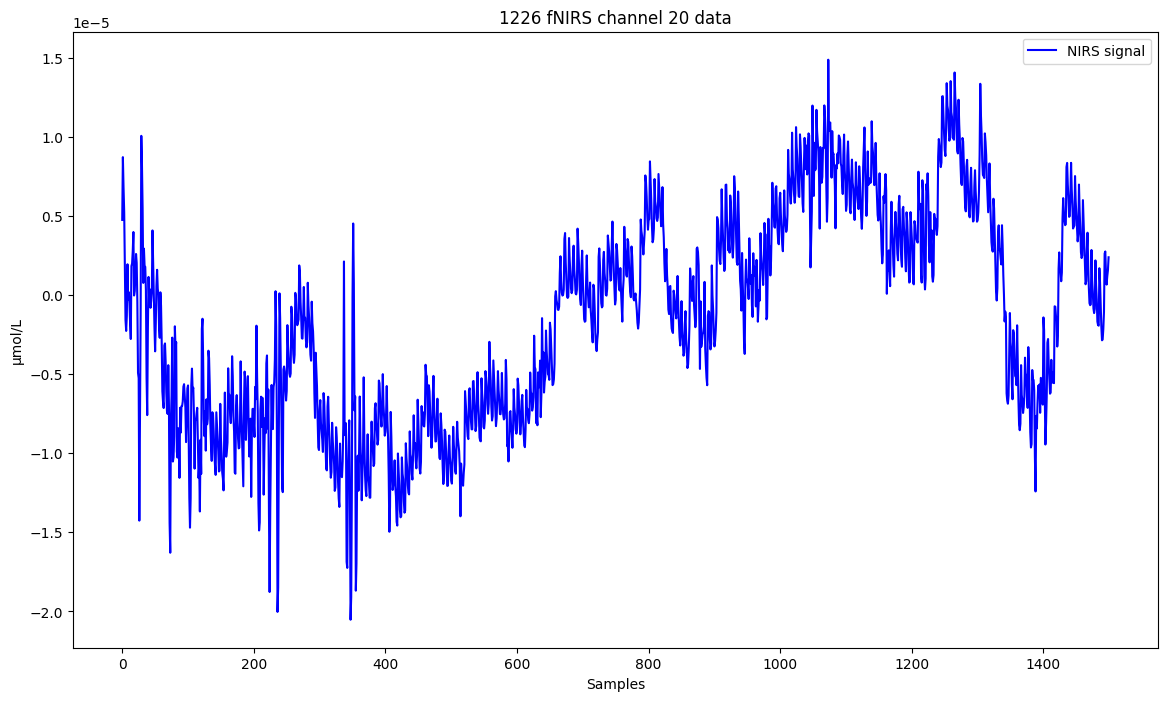

In [873]:

#Plot first couple seconds
print(f"Channel {channel} signal length: {data.shape[1]}")
# Plot the preprocessed and deconvolved data
plt.figure(figsize=(14, 8)) 
#plt.plot(preproc_data, color='blue', label='Preprocessed NIRS data')
plt.plot(data[0, :1500], color = 'blue', label = "NIRS signal")

plt.xlabel('Samples')
plt.ylabel('µmol/L')
plt.title(f'{subject_id} fNIRS channel {channel} data')

plt.legend(loc='best')

plt.show()


In [874]:
# Output skewness and kurtosis for channel signal

skewness = skew(data, axis = 1)  # Calculate skewness along the time dimension
kurtosis_ = kurtosis(data, axis = 1)  # Calculate kurtosis along the time dimension

print(f"Skewness: {round(skewness[0], 2)}\nKurtosis: {round(kurtosis_[0], 2)}")

Skewness: 0.31
Kurtosis: -0.23
